# 목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를  생성하여 회귀분석을 실시하고 결과를 해석하라.(BMI 계산 시, WEIGHT는 파운드(1lb0.45kg), HEIGHT는 인치(1inch2.54cm)이므로 변환하여 사용)
# 데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)

import warnings
import matplotlib as mp
import matplotlib.font_manager as fm
warnings.filterwarnings('ignore')
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mp.rc('font',family= font_name)

In [2]:
df_raw = pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/DIABETES.csv", engine = "python")
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


 2018년 비만진료지침에서 단계별 용어가 새롭게 변경되어 18.5 미만이면 저체중, 18.5∼23은 정상, 23~25이면 '비만 전단계'[5], 25∼30은 '1단계 비만', 30∼35는 '2단계 비만' , 35 이상이면 '3단계 비만'으로 구분한다.

복부비만을 측정하는 신체계측지표로 허리둘레(Waist
circumference; WC), 허리/엉덩이 둘레비(Waist-to-hip ratio; WHR), 허리/신장비(Waist-to-height
ratio; WHtR)

In [3]:
# sns.pairplot(df_raw)

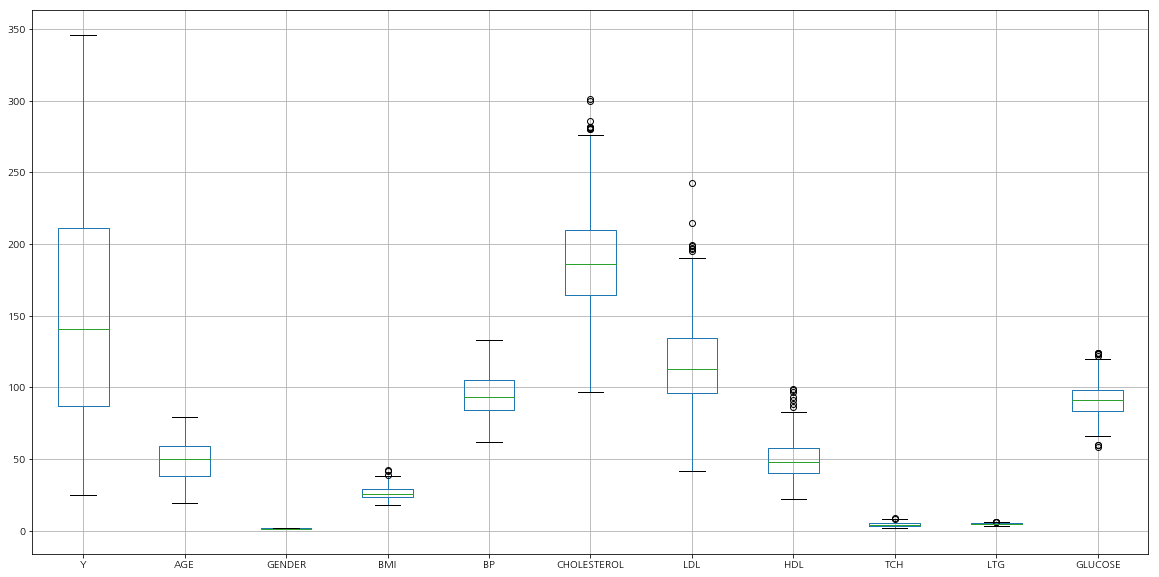

In [4]:
df_raw.boxplot(figsize=(20,10))

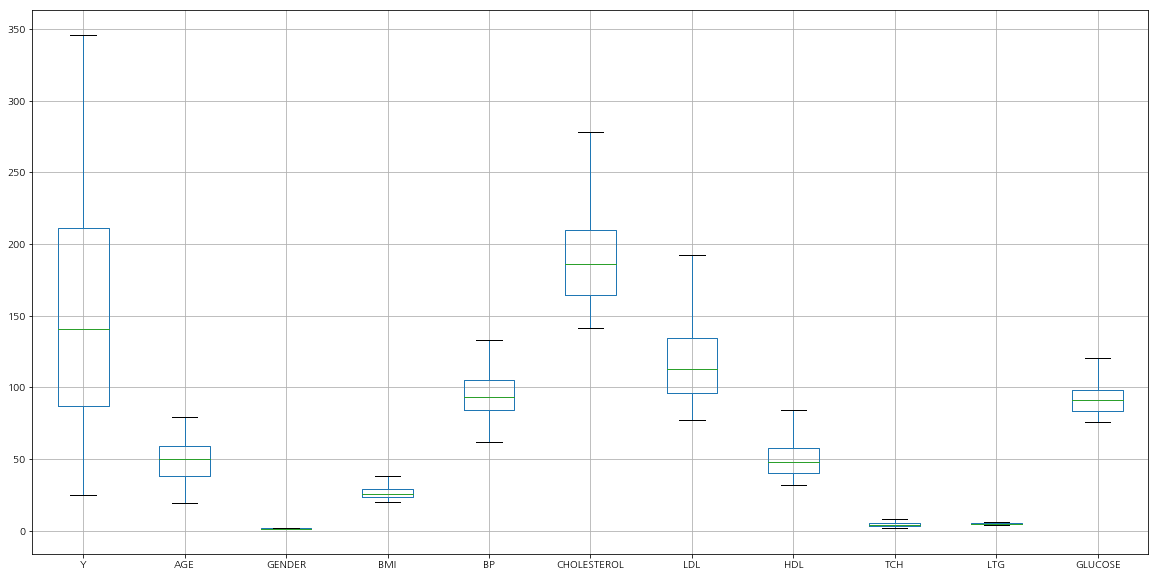

In [5]:
for x in df_raw.columns:
   if x != 'Y' and x != 'AGE' and x != 'GENDER' and x != 'BP' :
       a = np.percentile(df_raw[x],[25,75])
       l = a[1] + 1.5*(a[1]-a[0])
       u = a[1] - 1.5*(a[1]-a[0])
    
       df_raw[x][df_raw[x]>l] = l
       df_raw[x][df_raw[x]<u] = u 
        
df_raw.boxplot(figsize=(20,10))

In [6]:
df_raw.describe().round(3)

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,152.133,48.518,1.468,26.404,94.647,189.912,116.326,49.768,4.067,4.654,91.625
std,77.093,13.109,0.500,4.295,13.831,32.543,27.832,12.268,1.280,0.500,10.638
min,25.000,19.000,1.000,20.162,62.000,141.500,76.825,31.500,2.000,3.916,75.875
25%,87.000,38.250,1.000,23.200,84.000,164.250,96.050,40.250,3.000,4.277,83.250
50%,140.500,50.000,1.000,25.700,93.000,186.000,113.000,48.000,4.000,4.620,91.000
75%,211.500,59.000,2.000,29.275,105.000,209.750,134.500,57.750,5.000,4.997,98.000
max,346.000,79.000,2.000,38.388,133.000,278.000,192.175,84.000,8.000,6.078,120.125


In [7]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["Y"]
df_raw_x = df_raw.drop(["Y","GENDER"], axis= 1, inplace = False)
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

NameError: name 'variance_inflation_factor' is not defined

In [65]:
df_raw_x_const = df_raw_x_const.drop("CHOLESTEROL", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
1,AGE,1.204
3,BP,1.408
8,GLUCOSE,1.451
2,BMI,1.471
7,LTG,2.180
4,LDL,2.802
5,HDL,3.633
6,TCH,7.704
0,const,222.549


In [66]:
# 
reg_model = smf.ols(formula = "Y ~ AGE+GLUCOSE+BP+BMI+LTG+LDL+HDL+TCH", data = df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     53.88
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           2.41e-60
Time:                        14:29:31   Log-Likelihood:                -2394.5
No. Observations:                 442   AIC:                             4807.
Df Residuals:                     433   BIC:                             4844.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -284.3463     39.082     -7.276      0.0

In [67]:
# 
reg_model = smf.ols(formula = "Y ~ GENDER+BP+BMI+LTG+HDL", data = df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     91.29
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           1.36e-65
Time:                        14:29:50   Log-Likelihood:                -2388.9
No. Observations:                 442   AIC:                             4790.
Df Residuals:                     436   BIC:                             4814.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -230.9403     37.441     -6.168      0.0

In [69]:
df_raw_y = df_raw["Y"]
df_raw_x = df_raw[["GENDER","BP","BMI","LTG","HDL"]]

In [71]:
# train_set_split(x:설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(309, 5)
train data Y size:(309,)
test data X size:(133, 5)
test data Y size:(133,)


In [75]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: -0.037


In [76]:
#parameter 값 출력
tree_uncustomized

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [77]:
train_score=[]; test_score=[]
para_leaf=[n_leaf * 1 for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

## for 문 띄어쓰기 주의!!

In [42]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.999
1,2,1.000,0.999
2,3,0.999,0.999
3,4,0.999,0.999
4,5,0.999,0.999
5,6,0.999,0.998
6,7,0.998,0.997
7,8,0.998,0.997
8,9,0.996,0.995
9,10,0.995,0.995


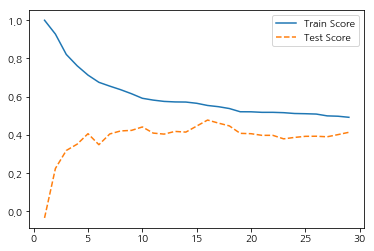

In [78]:
plt.plot(para_leaf,train_score,linestyle="-", label = "Train Score")
plt.plot(para_leaf,test_score,linestyle="--", label = "Test Score")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 node 선정

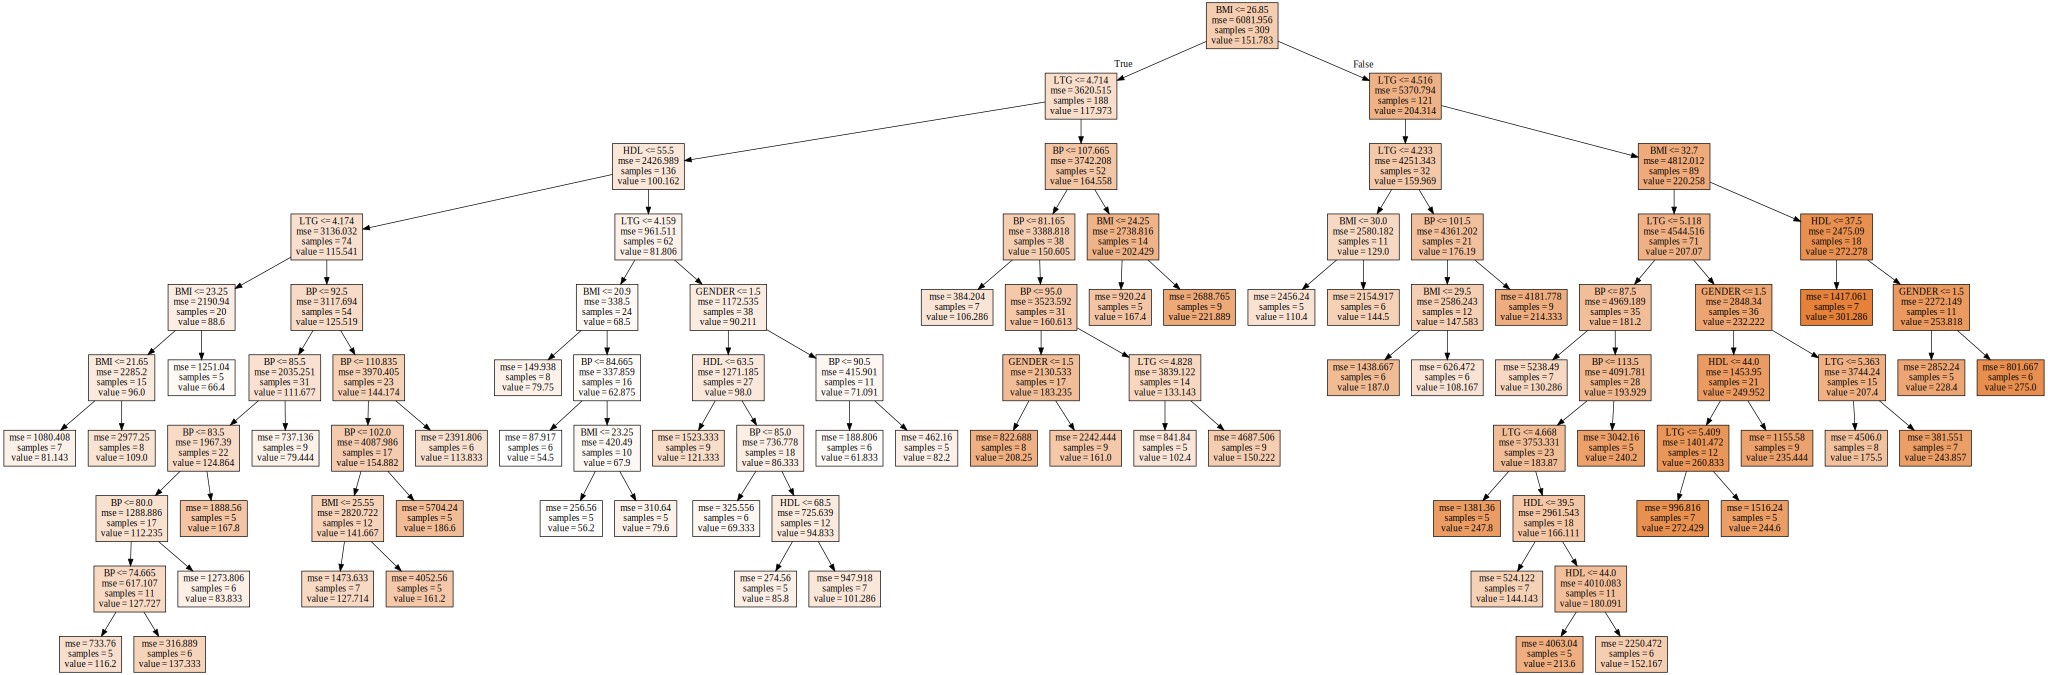

In [80]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=5)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

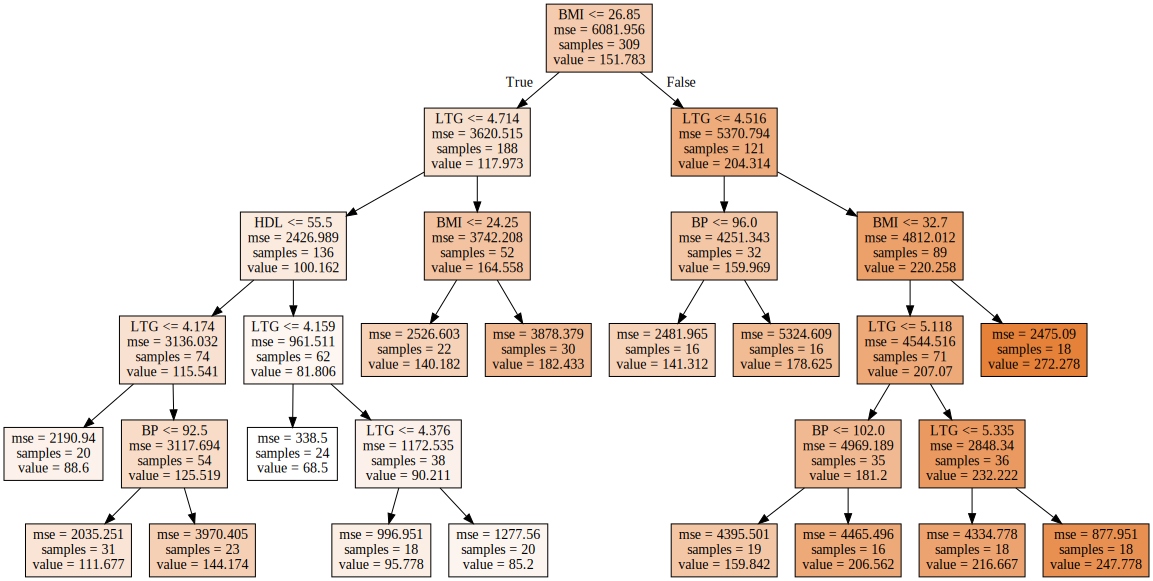

In [81]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=16)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

In [90]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(5,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=5, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,10,0.712,0.405
1,12,0.700,0.402
2,14,0.687,0.399
3,16,0.667,0.392
4,18,0.654,0.393
5,20,0.644,0.396
6,22,0.629,0.390
7,24,0.604,0.407
8,26,0.604,0.417
9,28,0.600,0.421


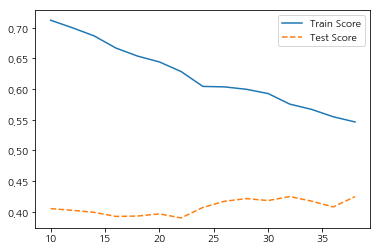

In [91]:
plt.plot(para_split,train_score,linestyle="-", label = "Train Score")
plt.plot(para_split,test_score,linestyle="--", label = "Test Score")
plt.legend()

In [92]:
# 

train_score = []; test_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(4,11)]

for v_max_depth in para_depth :
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 5, min_samples_split = 28, max_depth = v_max_depth )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,4,0.544,0.442
1,5,0.586,0.427
2,6,0.600,0.421
3,7,0.600,0.421
4,8,0.600,0.421
5,9,0.600,0.421
6,10,0.600,0.421


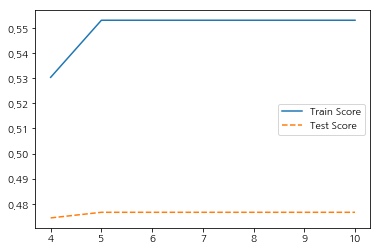

In [85]:
# 최대 깊이 증가에 따라 모델의 설명력은 증가
# Train/test 데이터의 성능 변화를 고려하여 4 선택
plt.plot(para_depth,train_score,linestyle="-", label = "Train Score")
plt.plot(para_depth,test_score,linestyle="--", label = "Test Score")
plt.legend()

In [93]:
# p. 174

tree_final = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=28, max_depth = 46, random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(criterion='mse', max_depth=46, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=28, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

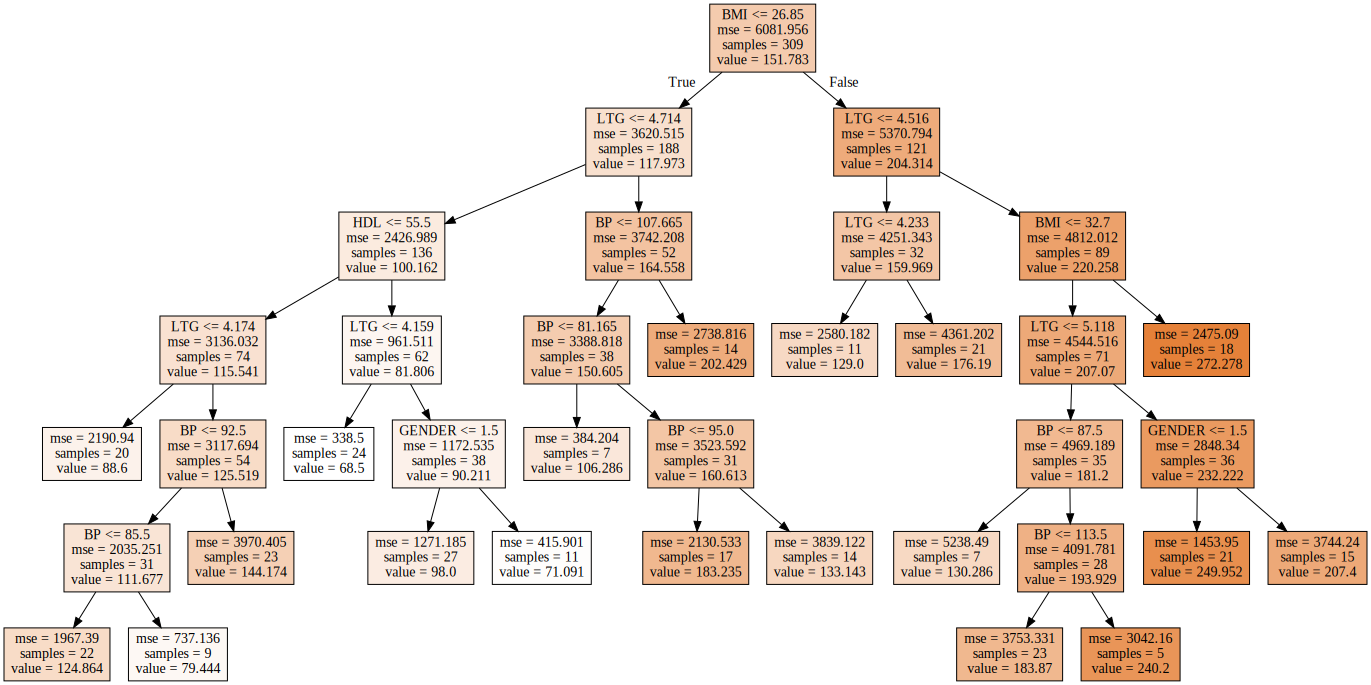

In [94]:
export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [95]:
train_score_final=[]; test_score_final=[]

train_score_final.append(tree.score(df_train_x, df_train_y))
test_score_final.append(tree.score(df_test_x, df_test_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [5]
df_score_final["TrainScore"]=train_score_final
df_score_final["TestScore"]=test_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,5,0.6,0.421


In [96]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_final.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.541
3,LTG,0.293
1,BP,0.112
4,HDL,0.034
0,GENDER,0.019
